# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Dyn3d"), "src/Dyn3d.jl"))
using Dyn3d
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body. Here is a plate:

In [4]:
n = 50;
body = Bodies.NACA4(0.0,0.0,0.15,np=n);

In [5]:
ds = Bodies.dlength(body);


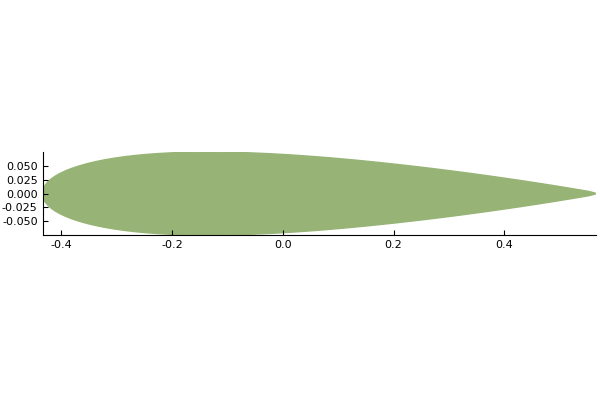

In [6]:
plot(body)

Set the body motion. Make it stationary.

In [7]:
motion = RigidBodyMotion(0.0,0.0)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

Transform the body with a specified initial position and orientation.

In [8]:
cent = (1.0,1.0) #1.0+1.0im
α = -π/4 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Whirl.Bodies.NACA4{99}(1.0, 0.0, 0.0, 0.15, (1.0, 1.0), -0.7853981633974483, [0.565653, 0.562053, 0.551998, 0.537357, 0.519685, 0.499676, 0.477777, 0.454319, 0.429561, 0.403716  …  0.376968, 0.403716, 0.429561, 0.454319, 0.477777, 0.499676, 0.519685, 0.537357, 0.551998, 0.562053], [2.72255e-18, 0.00141604, 0.00394545, 0.00644564, 0.00940583, 0.0126837, 0.016184, 0.0198359, 0.0235839, 0.0273832  …  -0.0311963, -0.0273832, -0.0235839, -0.0198359, -0.016184, -0.0126837, -0.00940583, -0.00644564, -0.00394545, -0.00141604], [1.39998, 1.39843, 1.39311, 1.38453, 1.37412, 1.36229, 1.34928, 1.33528, 1.32042, 1.30483  …  1.2445, 1.26611, 1.28707, 1.30723, 1.3264, 1.34436, 1.36082, 1.37541, 1.38753, 1.39643], [0.600023, 0.60357, 0.612468, 0.624589, 0.639178, 0.655644, 0.673604, 0.692774, 0.712931, 0.733892  …  0.711384, 0.695167, 0.679578, 0.664722, 0.650716, 0.637707, 0.625876, 0.615474, 0.606889, 0.601567])

Set up the domain

In [9]:
xlim = (0.0,4.0)
ylim = (0.0,2.0)

(0.0, 2.0)


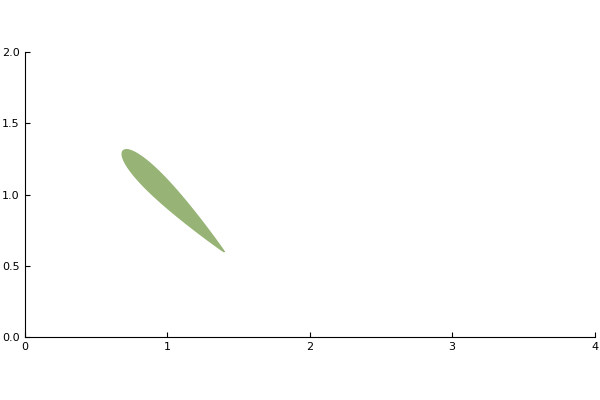

In [10]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [11]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [12]:
nx = 202; ny = 102;
Ly = ylim[2]-ylim[1];
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [13]:
u = w₀
f = VectorData(X̃);
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

Set up the integrator here

In [14]:
ifherk = IFHERK(u,f,sys.Δt,
                (t,u) -> plan_intfact(t,u,sys),
                (u,t) -> plan_constraints(u,t,sys),
                ((u,t) -> Whirl.TimeMarching.r₁(u,t,sys),
                 (u,t) -> Whirl.TimeMarching.r₂(u,t,sys)),rk=RK31)

Order-3+ IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{99}
   Time step size 0.01


Initialize the state vector and the history vectors

In [15]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [16]:
tf = 2.0;
T = Δt:Δt:tf;

In [17]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

962.612146 seconds (1.29 G allocations: 172.091 GiB, 2.58% gc time)
solution completed through time t = 2.0000000000000013


#### Plotting

Basic plot


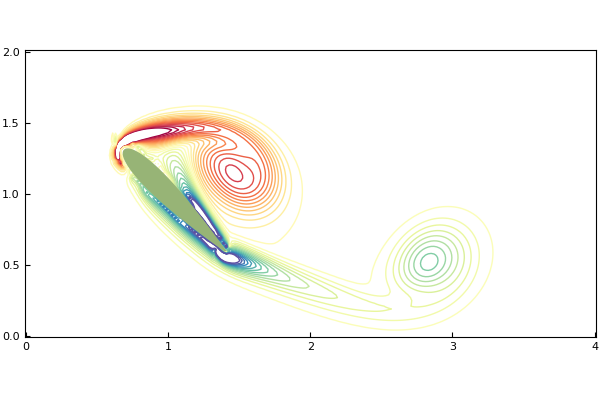

In [18]:
plot(xg,yg,uhist[end],levels=linspace(-0.25,0.25,30))
plot!(body)

Make a movie

In [19]:
@gif for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=linspace(-0.5,0.5,30))
    plot!(body)
end

INFO: Saved animation to /mnt/g/Research/Whirl.jl/examples/tmp.gif


Plots.AnimatedGif("/mnt/g/Research/Whirl.jl/examples/tmp.gif")

In [20]:
t

2.0000000000000013

In [21]:
fx

200-element Array{Float64,1}:
 -59.7502  
   0.954293
   0.922033
   0.896978
   0.87926 
   0.867417
   0.859735
   0.854826
   0.851742
   0.849879
   0.848844
   0.848361
   0.848218
   ⋮       
   0.879231
   0.878066
   0.876866
   0.875631
   0.874362
   0.873059
   0.871722
   0.870352
   0.868948
   0.867511
   0.866042
   0.86454 

In [22]:
fy

200-element Array{Float64,1}:
 -43.3609  
   0.455103
   0.485581
   0.515614
   0.545465
   0.574822
   0.603179
   0.630118
   0.655403
   0.678972
   0.700869
   0.721182
   0.740008
   ⋮       
   0.983943
   0.980833
   0.977668
   0.974449
   0.971175
   0.967847
   0.964464
   0.961028
   0.957538
   0.953994
   0.950397
   0.946748


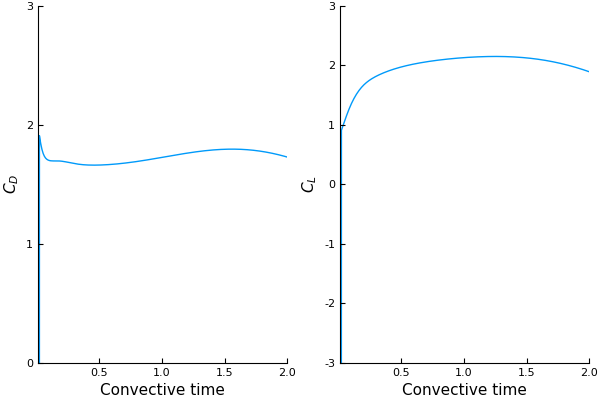

In [25]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)


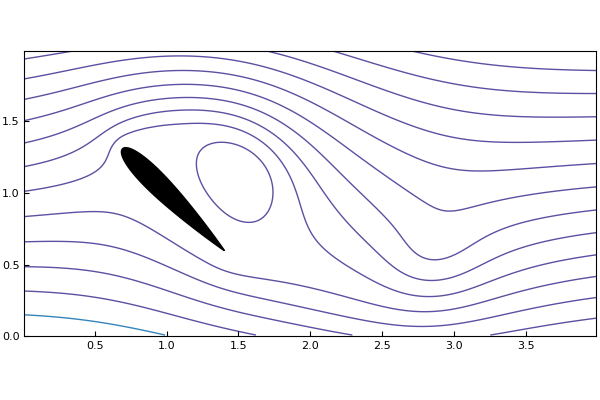

In [24]:
xg,yg = coordinates(u,dx=Δx)
ψ = deepcopy(u)
ψ .= -(sys.L\u)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)